In [37]:
import math, warnings
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import scipy.stats as st

In [38]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [39]:
df = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_0.csv")

In [40]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    # 1. mid_price & spread
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread']    = df['ask_price1'] - df['bid_price1']
    
    # 2. imbalance & book_pressure & microprice
    with np.errstate(divide='ignore', invalid='ignore'):
        num  = df['bid_size1'] - df['ask_size1']
        den  = df['bid_size1'] + df['ask_size1']
        df['imbalance'] = np.where(den > 0, num / den, np.nan)

        num2 = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
        den2 = df[['bid_size1','bid_size2','ask_size1','ask_size2']].sum(axis=1)
        df['book_pressure'] = np.where(den2 > 0, num2 / den2, np.nan)

        num3 = (df['ask_price1'] * df['bid_size1'] +
                df['bid_price1'] * df['ask_size1'])
        df['microprice'] = np.where(den > 0, num3 / den, np.nan)

    # 3. normalized_spread & L2 OBI
    df['normalized_spread'] = df['spread'] / df['mid_price'].replace(0, np.nan)
    df['OBI_L2'] = np.where(den2 > 0, (df['bid_size1'] + df['bid_size2']) / den2, np.nan)

    # 4. LOB entropy
    sizes = df[['bid_size1','bid_size2','ask_size1','ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p = np.divide(sizes, total, where=total != 0)
    entropy = -np.nansum(np.where(p > 0, p * np.log(p), 0), axis=1)
    df['LOB_entropy'] = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)

    # 5. log returns
    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 6. Realized volatility (safe: no leakage)
    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: np.sqrt((x.shift(1) ** 2)
                                       .rolling(window=30, min_periods=1).sum()))
    )

    # 7. Bipower variance (safe: no leakage)
    df['bipower_var'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.abs().shift(1)
                       .rolling(2, min_periods=1)
                       .apply(lambda r: r[0] * r[1], raw=True)
                       .rolling(30, min_periods=1)
                       .mean())
    )

    # 8. WAP and its log return
    df['wap'] = (
        (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) /
        (df['bid_size1'] + df['ask_size1']).replace(0, np.nan)
    )
    df['log_wap_return'] = (
        df.groupby('time_id')['wap']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 9. Lag features (safe)
    for col in ['imbalance', 'book_pressure', 'log_return']:
        df[f'{col}_lag1'] = df.groupby('time_id')[col].shift(1)
        df[f'{col}_lag2'] = df.groupby('time_id')[col].shift(2)

    # 10. Rolling stats (safe)
    df['rolling_vol_30'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).std())
    )
    df['rolling_imbalance_mean_30'] = (
        df.groupby('time_id')['imbalance']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).mean())
    )

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df.dropna()

In [41]:
df = make_features(df)

In [42]:
df.dropna(subset=["realized_volatility"], inplace=True)

In [43]:
df = df.sort_values(["time_id", "seconds_in_bucket"])

In [44]:
feats = [
    c for c in df.columns
    if c not in {"stock_id", "time_id", "seconds_in_bucket", "realized_volatility"}
]

In [45]:
X = df[feats].values.astype(np.float32)
y = df["realized_volatility"].values.astype(np.float32)

In [46]:
time_ids = df["time_id"].values
blocks = np.unique(time_ids)
block_idx = {b: i for i, b in enumerate(blocks)}
block_indices = np.array([block_idx[t] for t in time_ids])

In [47]:
n_test_blocks = max(int(0.1 * len(blocks)), 1)
block_cv = TimeSeriesSplit(n_splits=5, test_size=n_test_blocks, gap=1)

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_rmse = float("inf")
best_state = None
best_scaler = None

In [49]:
class ANN_ARCH(nn.Module):
    def __init__(self, n_in: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

In [50]:
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(np.log(np.clip(y, a_min=1e-8, a_max=None))).float()

In [51]:
for fold, (train_block_idxs, val_block_idxs) in enumerate(block_cv.split(blocks), 1):
    train_mask = np.isin(block_indices, train_block_idxs)
    val_mask   = np.isin(block_indices, val_block_idxs)
    train_idx = np.where(train_mask)[0]
    val_idx   = np.where(val_mask)[0]

    scaler = StandardScaler().fit(X[train_idx])
    X_train = scaler.transform(X[train_idx])
    X_val   = scaler.transform(X[val_idx])

    X_train_t = torch.from_numpy(X_train).to(device)
    y_train_t = y_tensor[train_idx].to(device)
    X_val_t   = torch.from_numpy(X_val).to(device)
    y_val_t   = y_tensor[val_idx].to(device)

    train_ds = TensorDataset(X_train_t, y_train_t)
    val_ds   = TensorDataset(X_val_t,   y_val_t)
    train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=1024, shuffle=False)

    model = ANN_ARCH(n_in=X.shape[1]).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(50):
        model.train()
        for xb, yb in train_loader:
            opt.zero_grad()
            preds = model(xb).squeeze()
            loss = loss_fn(preds, yb)
            if not torch.isnan(loss):
                loss.backward()
                opt.step()

    model.eval()
    with torch.no_grad():
        preds = torch.cat([model(xb).cpu() for xb, _ in val_loader]).squeeze()
    rmse = torch.sqrt(((preds - y_val_t.cpu()) ** 2).mean())

    print(f"Fold {fold}: val RMSE (log-σ) = {rmse:.4f}")
    if rmse < best_rmse:
        best_rmse = rmse
        best_state = model.state_dict()
        best_scaler = scaler

Fold 1: val RMSE (log-σ) = 0.1972
Fold 2: val RMSE (log-σ) = 0.2611
Fold 3: val RMSE (log-σ) = 0.2194
Fold 4: val RMSE (log-σ) = 0.2019
Fold 5: val RMSE (log-σ) = 0.1896


In [52]:
scaler_full = StandardScaler().fit(X)
X_full = scaler_full.transform(X)
X_full_t = torch.from_numpy(X_full).to(device)
y_full_t = y_tensor.to(device)

full_ds = TensorDataset(X_full_t, y_full_t)
full_loader = DataLoader(full_ds, batch_size=1024, shuffle=True)

final_model = ANN_ARCH(n_in=X.shape[1]).to(device)
final_model.load_state_dict(best_state)
opt = torch.optim.Adam(final_model.parameters(), lr=1e-3)

In [53]:
final_model.train()
for epoch in range(50):
    for xb, yb in full_loader:
        opt.zero_grad()
        preds = final_model(xb).squeeze()
        loss = loss_fn(preds, yb)
        if not torch.isnan(loss):
            loss.backward()
            opt.step()

print(f"Best validation RMSE (log-σ) across folds = {best_rmse:.4f}")

Best validation RMSE (log-σ) across folds = 0.1896


In [54]:
final_model.eval()
with torch.no_grad():
    x_last = torch.from_numpy(
        scaler_full.transform(X[-1:].astype(np.float32))
    ).to(device)
    log_sigma = final_model(x_last).item()
    sigma = np.exp(log_sigma)  # final output

print(f"Forecast σ (realized volatility) for last tick = {sigma:.9f}")

Forecast σ (realized volatility) for last tick = 0.000589295


In [55]:
test_blocks = max(int(0.05 * len(X)), 1)
X_test  = scaler.transform(X[-test_blocks:])
y_test  = y[-test_blocks:]
log_y_test = np.log(np.clip(y_test, a_min=1e-8, a_max=None))

with torch.no_grad():
    X_tensor = torch.tensor(X_test).to(device)
    log_pred = model(X_tensor).cpu().numpy().ravel()

y_pred_sigma  = np.exp(log_pred)
y_true_sigma  = np.exp(log_y_test)

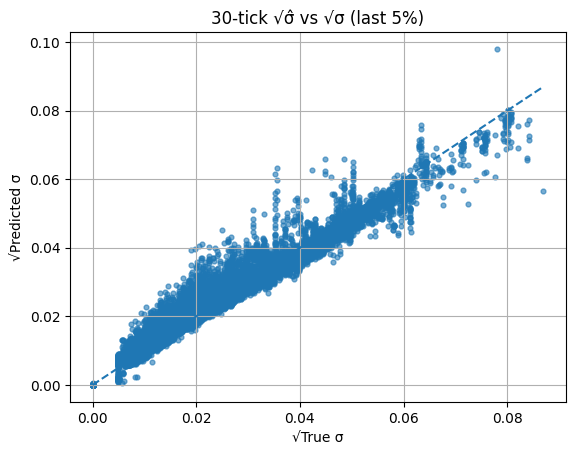

In [56]:
plt.figure()
plt.scatter(
    np.sqrt(y_true_sigma),
    np.sqrt(y_pred_sigma),
    s=12,
    alpha=0.6,
)
lims = [0, np.max(np.sqrt(y_true_sigma))]
plt.plot(lims, lims, linestyle="--")
plt.title("30-tick √σ̂ vs √σ (last 5%)")
plt.xlabel("√True σ")
plt.ylabel("√Predicted σ")
plt.grid()
plt.show()

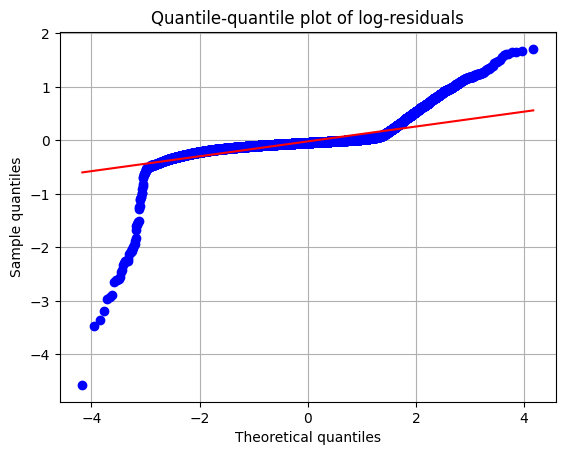

In [57]:
resid = np.log(y_pred_sigma) - np.log(y_test)
resid = resid[np.isfinite(resid)]

plt.figure()
st.probplot(resid, dist="norm", plot=plt)
plt.title("Quantile-quantile plot of log-residuals")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.grid(True)
plt.show()